In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from qiskit.providers.aer import QasmSimulator

from bitstring import Bits

To check whether $a \lt b$ or $a \geq b$,we can examine the flag bit in the $a-b$ operation.

1. First we change $b$ into 2's complement
2. And then add $a$ with $-b$
3. Check the MSB (Flag)

30


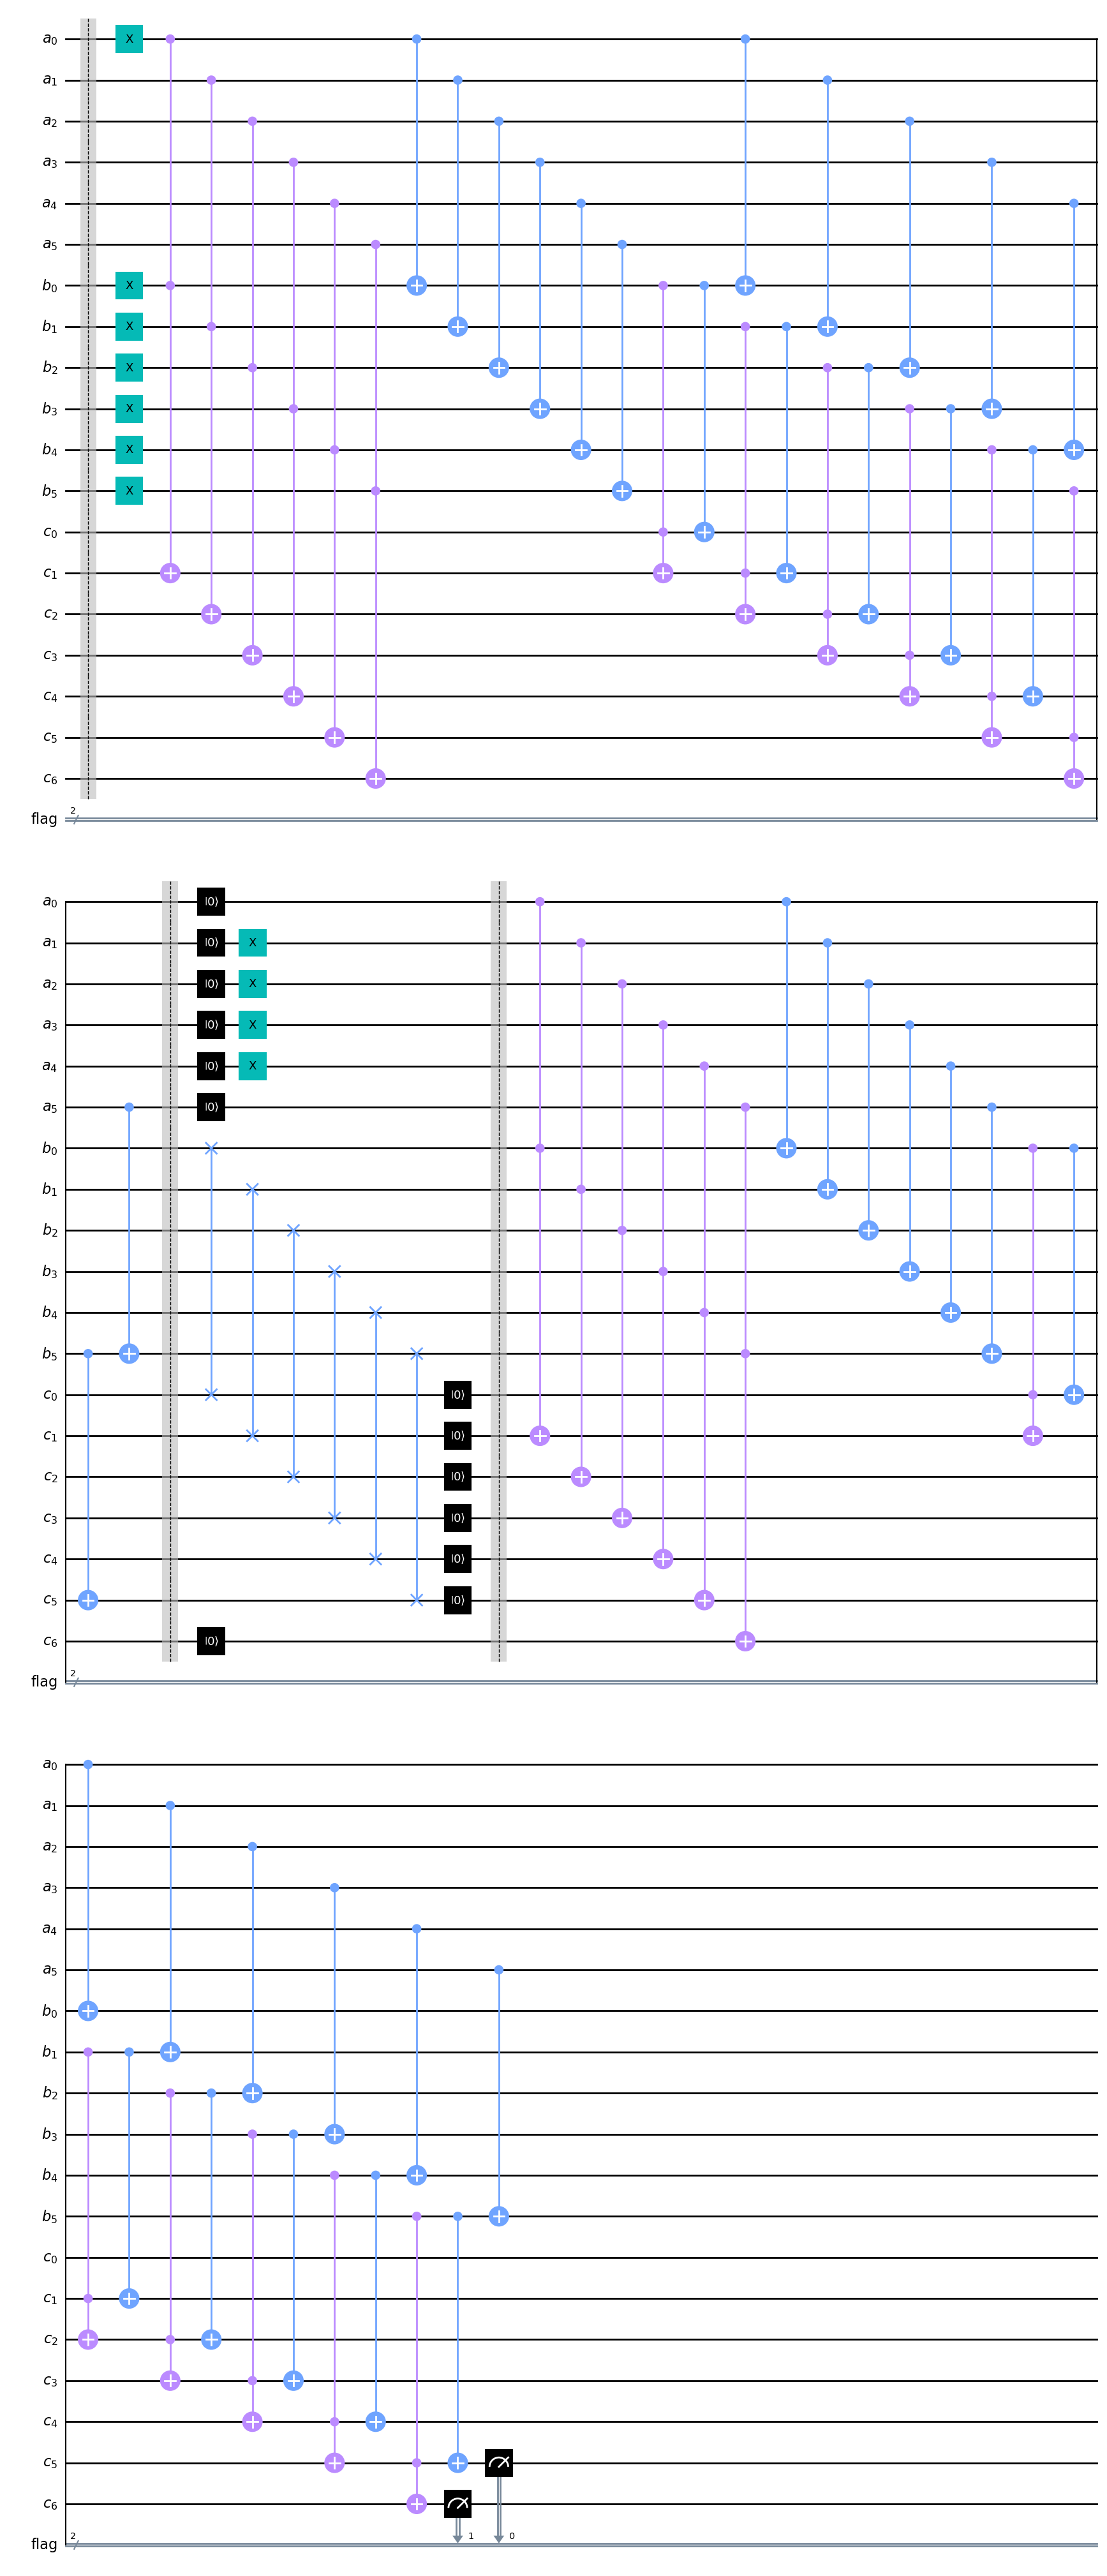

In [2]:
def find_the_largest_number(number_1, number_2):    
    # Define the number of qubits to represent the number
    N = 6

    # Create a Quantum Register with 3N + 1 qubits
    num1 = QuantumRegister(N, 'a')
    num2 = QuantumRegister(N, 'b')
    carry = QuantumRegister(N+1, 'c')

    # Create a Classical Register with N qubits
    flag = ClassicalRegister(2, 'flag')

    # Create the quantum circuit
    qc = QuantumCircuit()
    qc.add_register(num1)
    qc.add_register(num2)
    qc.add_register(carry)
    qc.add_register(flag)

    # init number
    x = Bits(int=number_1, length=N)
    y = Bits(int=number_2, length=N)
    
    for i, bit in enumerate(y.bin[::-1]):
        if bit == "1":
            qc.x(num2[i])

    # Transform b to 2's complement
    qc.barrier()

    # Flip qubits
    for i in range(N):
        qc.x(num2[i])

    # Add 1
    qc.x(num1[0])
    for i in range(N):
        qc.ccx(num1[i], num2[i], carry[i+1])
        qc.cx(num1[i], num2[i])
        qc.ccx(num2[i], carry[i], carry[i+1])
        qc.cx(num2[i], carry[i])
        qc.cx(num1[i], num2[i])
    # end 2's complement transform

    qc.barrier()
    
    # reset the qubits for next computation
    for i in range(N):
        qc.swap(num2[i], carry[i])

    for i in range(N):
        qc.reset(num1[i])
        qc.reset(carry[i])

    for i, bit in enumerate(x.bin[::-1]):
        if bit == "1":
            qc.x(num1[i])

    qc.reset(carry[N])
    
    qc.barrier()
    # Add a and -b
    for i in range(N):
        qc.ccx(num1[i], num2[i], carry[i+1])
        qc.cx(num1[i], num2[i])
        qc.ccx(num2[i], carry[i], carry[i+1])
        qc.cx(num2[i], carry[i])
        qc.cx(num1[i], num2[i])

    # measure flag
    qc.measure(carry[N], flag[1])
    qc.measure(carry[N-1], flag[0])

    # Simulate the circuit to obtain the measurement results
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=3)
    result = job.result()
    counts = result.get_counts(qc)

    # Print the measurement results
    flags = counts.most_frequent()

    # check overflow
    if (int(flags[0]) ^ int(flags[1])):
        print("Overflow!")

    # check flags
    if flags[0] == "1":
        print(number_2)
    else:
        print(number_1)

    return qc.draw("mpl")

find_the_largest_number(30, 0)